In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os, sys, simplejson
import seaborn as sns
from sklearn import linear_model
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
%matplotlib inline

PROJ_ROOT = os.path.abspath(os.path.join(os.pardir))
sys.path.append(os.path.join(PROJ_ROOT, 'src'))
import analysis

### Data preparation

In [2]:
totals = analysis.load_transform_trend()
totals = totals[totals['Count'] > 10]
pop, dt = analysis.produce_trends(totals)

next_year = pop[['Name','Sex','trend_2018']]
next_year['Year'] = 2018
next_year = next_year.rename(columns={'trend_2018':'Count'})
next_year['Rank'] = next_year.groupby(['Year','Sex'])['Count'].rank(ascending=False, method='first')
totals = totals.append(next_year)

8162it [03:10, 42.81it/s]
/Users/chrisdoughty/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Year vs. year top ranks

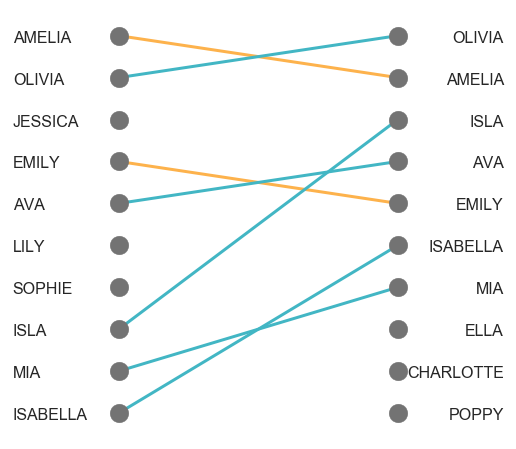

In [3]:
y1, y2 = analysis.year_data(totals, 2012, 2017, 'F')

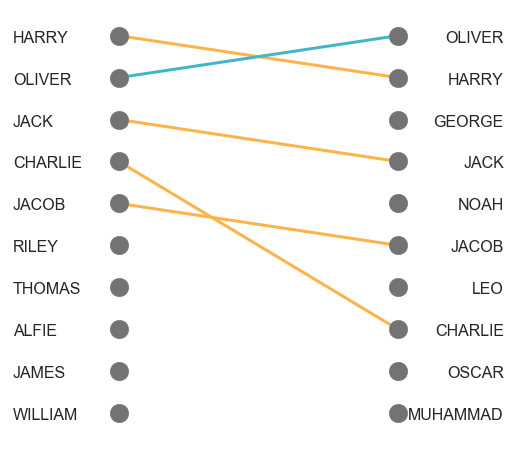

In [4]:
y1, y2 = analysis.year_data(totals, 2012, 2017, 'M')

### Name trend and change

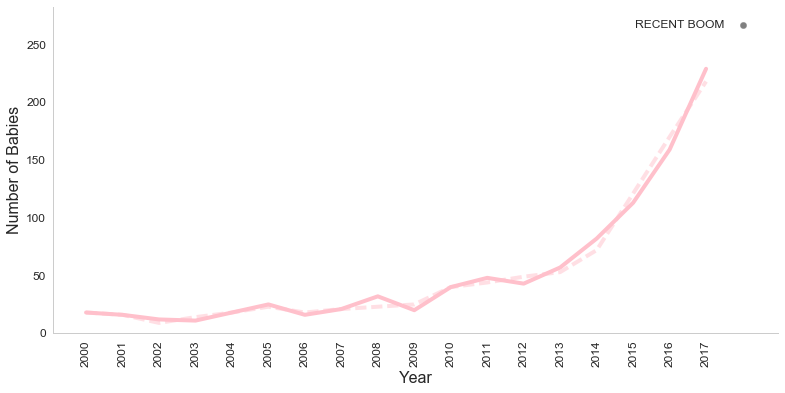

In [5]:
name = pop[(pop.Name == 'OTTILIE') & (pop.Sex == 'F')]

fig, ax = plt.subplots(figsize=(13,6))
plt.plot(dt[0:18], list(name['trend_data'].values[0]), c='pink', linewidth=4)
plt.plot(dt[0:18], list(name['batch_pred'].values[0]), c='pink', linewidth=4, linestyle='--', alpha=0.5)
plt.scatter(x=2018, y=name['trend_2018'].values, s=40, c='grey')
ax.annotate(name['trend_profile'].values[0], (2017.5, name['trend_2018'].values), fontsize=12, 
            horizontalalignment='right', verticalalignment='center')

plt.ylim(0,)
plt.ylabel('Number of Babies',fontsize=16)
plt.xlabel('Year',fontsize=16)
plt.xticks(np.arange(min(dt),max(dt)+1,1), fontsize=12, rotation=90)
plt.yticks(fontsize=12)
ax.grid(False)
sns.despine()
plt.show()

### Trends to names

In [6]:
# Load in our name data and show the format of the first row
frst = pd.read_csv('../data/interim/frstnames.csv')
print(len(frst))
frst.head(1)

31697


,Name,phonetics,phonetics_source,phonetics_space,final_sound,single,double
0,OLIVIA,OW0 L IH1 V IY0 AH0,dict,OW0LIH1VIY0AH0,AH0,O,OL


In [7]:
curr_year = totals[totals.Year == 2017]
curr_year = curr_year.drop('Year', axis=1)

next_year = totals[totals.Year == 2018]
next_year = next_year.rename(columns={'Count':'n_next','Rank':'Predicted Rank'})
next_year = next_year.drop('Year', axis=1)

data_merg = pd.merge(curr_year, next_year, on=['Name','Sex'], how='left')
data_merg['Predicted Change'] = data_merg['n_next'] - data_merg['Count']

new = pd.merge(pop, frst, on='Name', how='left')
new = pd.merge(new, data_merg, on=['Name','Sex'], how='left')

new.to_csv('../data/interim/frstnames_pop.csv', index=False, encoding=False)
new.head()

,Name,Sex,trend_data,trend_profile,trend_pred,trend_score,trend_coef,trend_2018,batch_pred,batch_score,...,phonetics_source,phonetics_space,final_sound,single,double,Count,Rank,n_next,Predicted Rank,Predicted Change
0,A,M,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 15, 0, 0,...",CURRENTLY STABLE,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, ...",0.10,0.26,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 4, 6, 4, ...","[1.0, 1.0, 1.0, 0.07, 0.07]",...,dict,AH0,AH0,A,A,NaN,NaN,NaN,NaN,NaN
1,A-JAY,M,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12, 0,...",CURRENTLY STABLE,"[-1, -1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 3...",0.20,0.32,12,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2, 1, 4, 8, -2...","[1.0, 1.0, 1.0, 0.6, 0.6]",...,pred,AH0JHEY1,EY1,A,A-,12.0,1972.0,12.0,1912.0,0.0
2,AABAN,M,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 19, 13, ...",CURRENTLY STABLE,"[-1, 0, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6,...",0.17,0.54,-10,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 8, 13, 17, 1...","[1.0, 1.0, 1.0, 0.59, 0.6]",...,pred,AH0BAH0N,N,A,AA,NaN,NaN,NaN,NaN,NaN
3,AADAM,M,"[42, 51, 77, 72, 70, 84, 69, 77, 77, 87, 63, 8...",CURRENTLY STABLE,"[48, 53, 57, 62, 66, 71, 75, 80, 84, 88, 93, 9...",0.69,4.46,127,"[42, 51, 72, 74, 76, 78, 69, 74, 80, 85, 63, 7...","[1.0, 0.15, 0.89, 0.99, 0.0]",...,pred,EY1DAH0M,M,A,AA,108.0,433.0,127.0,388.0,19.0
4,AADHYA,F,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 15, 17, 3...",CURRENTLY STABLE,"[-8, -6, -4, -2, 0, 1, 3, 5, 7, 9, 11, 13, 15,...",0.68,2.05,30,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 4, 11, 17, ...","[1.0, 1.0, 1.0, 0.84, 0.04]",...,pred,AH0DIY0AH0AH0,AH0,A,AA,30.0,1181.0,30.0,1199.0,0.0


In [7]:
new = pd.read_csv('../data/interim/frstnames_pop.csv')
new_red = new.drop(['trend_pred','trend_score','trend_coef','batch_pred',
                    'phonetics_source','batch_coef','batch_score'], axis=1)
new_red = new_red[new_red['Count'] == new_red['Count']]

def fx(x):
    x = x[1:-1].split(', ')
    x = list(map(int, x))
    return x

new_red['trend_data'] = new_red.trend_data.apply(fx)
#new_red['batch_pred'] = new_red.batch_pred.apply(fx)

js = new_red.to_json(orient='records')
DataFile = open('../data/interim/frstnames_pop.json','w')
DataFile.write(simplejson.dumps(simplejson.loads(js), indent=4, sort_keys=True))
DataFile.close()

new_redd = new_red[new_red['Count'] >= 50]
js = new_redd.to_json(orient='records')
DataFile = open('../data/interim/frstnames_pop_red.json','w')
DataFile.write(simplejson.dumps(simplejson.loads(js), indent=4, sort_keys=True))
DataFile.close()

In [9]:
set(new_red['trend_profile'].values)

{'CONTINUED DECLINE',
 'CURRENTLY STABLE',
 'DECLINE STABILISING',
 'GROWING BOOM',
 'GROWTH STABILISING',
 'RECENT BOOM',
 'RECENT DECLINE'}

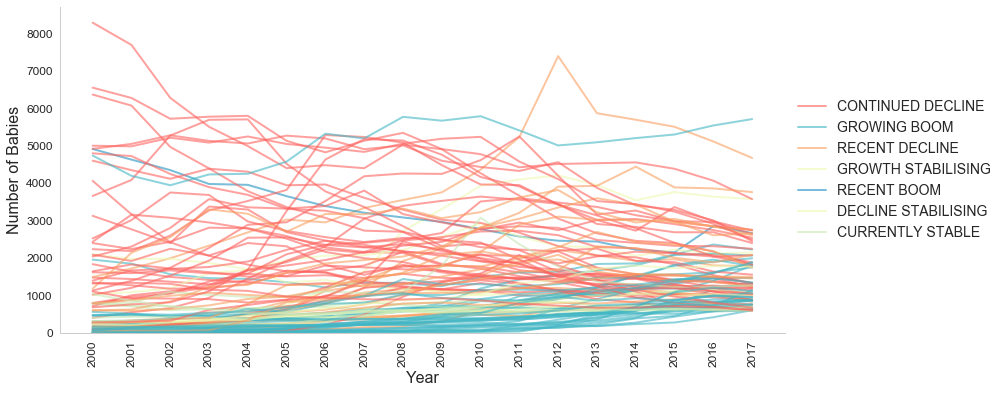

In [10]:
from collections import OrderedDict

hund_plot = new_red[(new_red['Sex'] == 'F') & (new_red['Rank'] < 100)]
dt = list(range(2000,2018,1))

fig, ax = plt.subplots(figsize=(13,6))

for index, row in hund_plot.iterrows():
    if row['trend_profile'] == 'STABILITY' or row['trend_profile'] == 'CURRENTLY STABLE':
        cl = '#C7E9B4' 
    elif row['trend_profile'] == 'RECENT BOOM':
        cl = '#1E91C0'
    elif row['trend_profile'] == 'RECENT DECLINE':
        cl = '#F99F60'
    elif row['trend_profile'] == 'CONTINUED DECLINE':
        cl = '#FE625E'
    elif row['trend_profile'] == 'GROWING BOOM':
        cl = '#42B6C4'
    else:
        cl = '#EDF9B1'
    
    plt.plot(dt[0:18], row['trend_data'], c=cl, linewidth=2, alpha=0.6, label=row['trend_profile'])
    
plt.ylim(0,)
plt.ylabel('Number of Babies',fontsize=16)
plt.xlabel('Year',fontsize=16)
plt.xticks(np.arange(min(dt),max(dt)+1,1), fontsize=12, rotation=90)
plt.yticks(fontsize=12)

handles, labels = plt.gca().get_legend_handles_labels()
by_labels = OrderedDict(zip(labels, handles))
plt.legend(by_labels.values(), by_labels.keys(), loc='center left', bbox_to_anchor=(1,0.5), fontsize=14)
ax.grid(False)
sns.despine()
plt.show()   

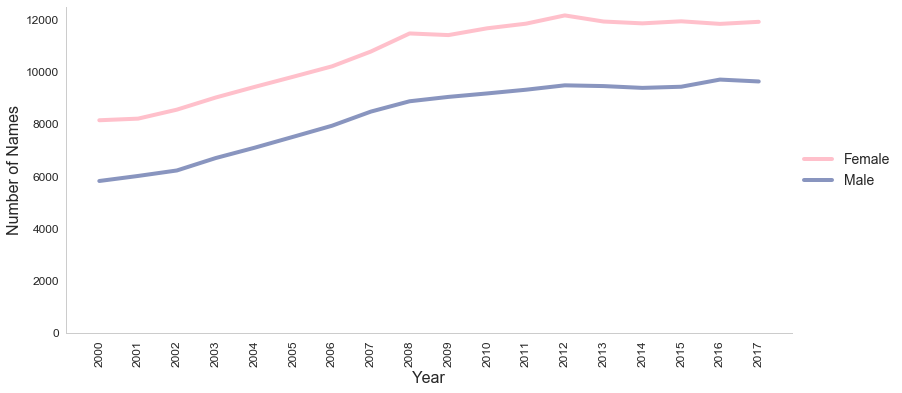

In [5]:
frst = pd.read_csv('../data/raw/names/firstnames.csv')
frst['Count'] = 1
frst = frst[['Year','Sex','Count']].groupby(['Year','Sex']).sum().reset_index()

fig, ax = plt.subplots(figsize=(13,6))

F = frst[frst['Sex'] == 'F']
M = frst[frst['Sex'] == 'M']

plt.plot(dt[0:18], F['Count'], c='pink', linewidth=4, alpha=1, label='Female')
plt.plot(dt[0:18], M['Count'], c='#8995BF', linewidth=4, alpha=1, label='Male')
    
plt.ylim(0,)
plt.ylabel('Number of Names',fontsize=16)
plt.xlabel('Year',fontsize=16)
plt.xticks(np.arange(min(dt),max(dt)+1,1), fontsize=12, rotation=90)
plt.yticks(fontsize=12)

plt.legend(loc='center left', bbox_to_anchor=(1,0.5), fontsize=14)
ax.grid(False)
sns.despine()
plt.show()   

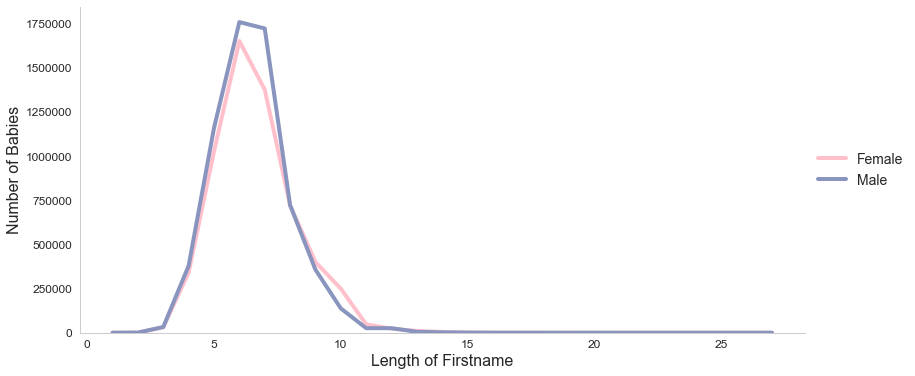

In [30]:
frst = pd.read_csv('../data/raw/names/firstnames.csv')
frst['Length'] = frst['Name'].str.len()
frst['Count'] = frst['Count'].str.replace(',','')
frst['Count'] = frst['Count'].astype(int)
frst = frst[['Length','Sex','Count']].groupby(['Length','Sex']).sum().reset_index()

fig, ax = plt.subplots(figsize=(13,6))

F = frst[frst['Sex'] == 'F']
M = frst[frst['Sex'] == 'M']

plt.plot(F['Length'], F['Count'], c='pink', linewidth=4, alpha=1, label='Female')
plt.plot(F['Length'], M['Count'], c='#8995BF', linewidth=4, alpha=1, label='Male')
    
plt.ylim(0,)
plt.ylabel('Number of Babies',fontsize=16)
plt.xlabel('Length of Firstname',fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(loc='center left', bbox_to_anchor=(1,0.5), fontsize=14)
ax.grid(False)
sns.despine()
plt.show()   

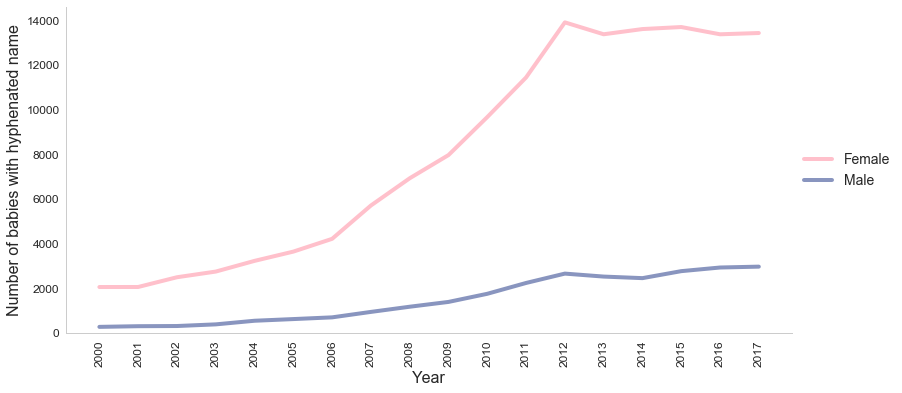

In [33]:
frst = pd.read_csv('../data/raw/names/firstnames.csv')
frst['hyphen'] = frst['Name'].str.contains('-', regex=False)
frst = frst[frst['hyphen'] == True]
frst['Count'] = frst['Count'].str.replace(',','')
frst['Count'] = frst['Count'].astype(int)
frst = frst[['Year','Sex','Count']].groupby(['Year','Sex']).sum().reset_index()

fig, ax = plt.subplots(figsize=(13,6))

F = frst[frst['Sex'] == 'F']
M = frst[frst['Sex'] == 'M']

plt.plot(dt[0:18], F['Count'], c='pink', linewidth=4, alpha=1, label='Female')
plt.plot(dt[0:18], M['Count'], c='#8995BF', linewidth=4, alpha=1, label='Male')
    
plt.ylim(0,)
plt.ylabel('Number of babies with hyphenated name',fontsize=16)
plt.xlabel('Year',fontsize=16)
plt.xticks(np.arange(min(dt),max(dt)+1,1), fontsize=12, rotation=90)
plt.yticks(fontsize=12)

plt.legend(loc='center left', bbox_to_anchor=(1,0.5), fontsize=14)
ax.grid(False)
sns.despine()
plt.show()   

In [3]:
lstnames = pd.read_csv('../data/interim/lastnames.csv')
lstnames = lstnames[['Surname','phonetics_space']]

js = lstnames.to_json(orient='records')
DataFile = open('../data/interim/lastnames_pop.json','w')
DataFile.write(simplejson.dumps(simplejson.loads(js), indent=4, sort_keys=True))
DataFile.close()

### Syllables

In [584]:
syll = lambda w:len(''.join(c if c in"aeiouy"else' 'for c in w.rstrip('e')).split())
a = syll("amelia")
print(a)

3
